# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
!pip install tensorflow_addons
import tensorflow.compat.v2 as tf
from typing import Union
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dropout, Dense
import matplotlib.pyplot as plt
import os
import shutil
import pandas as pd
tf.enable_v2_behavior()
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow_addons as tfa
from tensorflow.keras.models import load_model as load
from scipy.ndimage.interpolation import zoom
from PIL import Image, ImageDraw

BATCH_SIZE = 32
NUM_EPOCHS = 12
NUM_CLASSES = 2  # 2 total classes.


# Data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# read annotations file
dict_from_csv = pd.read_csv('/content/drive/MyDrive/ECE1512/mhist_dataset/annotations.csv', header=0, index_col=0).to_dict()
rawimagedir = '/content/drive/MyDrive/ECE1512/mhist_dataset/images'

In [4]:
#!unzip -uq "/content/drive/MyDrive/ECE1512/mhist_dataset/images.zip" -d "/content/drive/MyDrive/ECE1512/mhist_dataset/"

In [ ]:
#spilt training and test set
for i in os.listdir(rawimagedir):
  if dict_from_csv['Partition'][i] == 'train':
    shutil.copyfile(os.path.join(rawimagedir,i),os.path.join('/content/drive/MyDrive/ECE1512/mhist_dataset/train',i))
  else:
    shutil.copyfile(os.path.join(rawimagedir,i),os.path.join('/content/drive/MyDrive/ECE1512/mhist_dataset/test',i))

In [18]:
#classify the images for train and test
test123 = []
for setdir in ['train','test']:
  #create folders for each label
  if not os.path.exists(os.path.join('/content/drive/MyDrive/ECE1512/',setdir,'HP')):
    os.makedirs(os.path.join('/content/drive/MyDrive/ECE1512/',setdir,'HP'))
  if not os.path.exists(os.path.join('/content/drive/MyDrive/ECE1512/',setdir,'SSA')):
    os.makedirs(os.path.join('/content/drive/MyDrive/ECE1512/',setdir,'SSA'))
  for i in os.listdir(os.path.join('/content/drive/MyDrive/ECE1512/mhist_dataset/',setdir)):
    if dict_from_csv['Majority Vote Label'][i] == 'HP':
      shutil.copyfile(os.path.join('/content/drive/MyDrive/ECE1512/mhist_dataset/',setdir,i),os.path.join('/content/drive/MyDrive/ECE1512/',setdir,'HP',i))
      #os.remove(os.path.join('/content/drive/MyDrive/ECE1512/mhist_dataset/',setdir,i))
    else:
      shutil.copyfile(os.path.join('/content/drive/MyDrive/ECE1512/mhist_dataset/',setdir,i),os.path.join('/content/drive/MyDrive/ECE1512/',setdir,'SSA',i))
      #os.remove(os.path.join('/content/drive/MyDrive/ECE1512/mhist_dataset/',setdir,i))

In [2]:
#load preprocessed data
train_dir = '/content/drive/MyDrive/ECE1512/train' #you should change to your directory
test_dir = '/content/drive/MyDrive/ECE1512/test' #you should change to your directory

#augmentation and train
train_datagen = ImageDataGenerator(rescale=1/255.,
shear_range=0.1,
rotation_range=15,
horizontal_flip=True,
vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=BATCH_SIZE,
shuffle=True)

test_generator = test_datagen.flow_from_directory(test_dir,
class_mode='categorical',
interpolation='bilinear',
target_size=(224, 224),
batch_size=BATCH_SIZE,
shuffle=False)

Found 2175 images belonging to 2 classes.
Found 977 images belonging to 2 classes.


# Model creation

In [3]:
# Build teacher.
ResNet50V2 = tf.keras.Sequential()

# your code start from here for stpe 2

ResNet50V2.add(tf.keras.applications.resnet_v2.ResNet50V2(input_shape = (224, 224, 3), classifier_activation = None))
ResNet50V2.add(tf.keras.layers.Dense(NUM_CLASSES)) 
ResNet50V2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 1000)              25613800  
                                                                 
 dense (Dense)               (None, 2)                 2002      
                                                                 
Total params: 25,615,802
Trainable params: 25,570,362
Non-trainable params: 45,440
_________________________________________________________________


In [4]:
# Build student.
MobileNetV2_kd = tf.keras.Sequential()

# your code start from here for step 2

MobileNetV2_kd.add(tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = (224, 224, 3), classifier_activation = None))
MobileNetV2_kd.add(tf.keras.layers.Dense(NUM_CLASSES)) 
MobileNetV2_kd.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dense_1 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 3,540,986
Trainable params: 3,506,874
Non-trainable params: 34,112
_________________________________________________________________


# Teacher loss function

In [5]:
@tf.function
def compute_teacher_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = ResNet50V2(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits))


  return cross_entropy_loss_value

# Student loss function

In [6]:
# Hyperparameters for distillation (need to be tuned).
#ALPHA = 0.5 # task balance between cross-entropy and distillation loss
#DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = MobileNetV2_kd(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3
  teacher_subclass_logits = ResNet50V2(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.
  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits))

  # Compute the total loss 
  total_loss = ALPHA*cross_entropy_loss_value+(1-ALPHA)*distillation_loss_value

  return total_loss

# Train and evaluation

In [22]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn, ALPHA, 
                       DISTILLATION_TEMPERATURE, LR = 1e-4, tune=False):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
  train_generator.reset()
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for batch in range(len(train_generator)):
      images, labels = train_generator.next()
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images, labels, ALPHA, DISTILLATION_TEMPERATURE)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = len(test_generator)*32 # 32 is batch size

    test_generator.reset()

    metric = tfa.metrics.F1Score(num_classes=2)

    for batch in range(len(test_generator)):
      # your code start from here for step 4
      images, labels = test_generator.next()
      num_correct += compute_num_correct(model,images,labels)[0]
      
      output = model(images, training=False)
      metric.update_state(labels, output)
    f1 = metric.result().numpy()
    print('Class_accuracy: ',round(num_correct.numpy() / num_total * 100,4),'%\n',
          'F1-score of label 0 and label 1: ',f1,'Macro-F1: ',round(f1.sum()/2,4))
  if tune:
    return round(num_correct.numpy() / num_total * 100,4)


# Training models

In [9]:
# your code start from here for step 5 
# Teacher Model
# initial
NUM_EPOCHS = 10
train_and_evaluate(ResNet50V2, compute_teacher_loss, 0.5, 4,LR=0.0001)
# fine
NUM_EPOCHS = 25
train_and_evaluate(ResNet50V2, compute_teacher_loss, 0.5, 4,LR=0.00001)

Epoch 1: Class_accuracy:  69 %
 F1-score of label 0 and label 1:  [0.8026756 0.3572985] Macro-F1:  0.58
Epoch 2: Class_accuracy:  68 %
 F1-score of label 0 and label 1:  [0.8018313 0.2870588] Macro-F1:  0.54
Epoch 3: Class_accuracy:  79 %
 F1-score of label 0 and label 1:  [0.8590022 0.6584938] Macro-F1:  0.76
Epoch 4: Class_accuracy:  78 %
 F1-score of label 0 and label 1:  [0.85219896 0.63844794] Macro-F1:  0.75
Epoch 5: Class_accuracy:  73 %
 F1-score of label 0 and label 1:  [0.82688385 0.46985447] Macro-F1:  0.65
Epoch 6: Class_accuracy:  77 %
 F1-score of label 0 and label 1:  [0.8480463 0.6328671] Macro-F1:  0.74
Epoch 7: Class_accuracy:  81 %
 F1-score of label 0 and label 1:  [0.86498857 0.7247278 ] Macro-F1:  0.79
Epoch 8: Class_accuracy:  75 %
 F1-score of label 0 and label 1:  [0.83542544 0.54615384] Macro-F1:  0.69
Epoch 9: Class_accuracy:  80 %
 F1-score of label 0 and label 1:  [0.8630644 0.6932007] Macro-F1:  0.78
Epoch 10: Class_accuracy:  81 %
 F1-score of label 0 and

In [13]:
ResNet50V2.save("Teacher_Model_4.h5")
ResNet50V2.save_weights("Teacher_Weights_4")

In [11]:
# Student Model: ALPHA=0.5, DISTILLATION_TEMPERATURE=4
NUM_EPOCHS = 10
train_and_evaluate(MobileNetV2_kd, compute_student_loss, 0.5, 4,LR=0.001)
NUM_EPOCHS = 25
train_and_evaluate(MobileNetV2_kd, compute_student_loss, 0.5, 4,LR=0.0001)

Epoch 1: Class_accuracy:  62 %
 F1-score of label 0 and label 1:  [0.7741531 0.       ] Macro-F1:  0.39
Epoch 2: Class_accuracy:  61 %
 F1-score of label 0 and label 1:  [0.6343874 0.6072187] Macro-F1:  0.62
Epoch 3: Class_accuracy:  62 %
 F1-score of label 0 and label 1:  [0.7741531 0.       ] Macro-F1:  0.39
Epoch 4: Class_accuracy:  66 %
 F1-score of label 0 and label 1:  [0.7919113  0.24228029] Macro-F1:  0.52
Epoch 5: Class_accuracy:  48 %
 F1-score of label 0 and label 1:  [0.32108843 0.5906481 ] Macro-F1:  0.46
Epoch 6: Class_accuracy:  51 %
 F1-score of label 0 and label 1:  [0.38341966 0.59729266] Macro-F1:  0.49
Epoch 7: Class_accuracy:  62 %
 F1-score of label 0 and label 1:  [0.62025315 0.64214706] Macro-F1:  0.63
Epoch 8: Class_accuracy:  38 %
 F1-score of label 0 and label 1:  [0.06279434 0.5466971 ] Macro-F1:  0.3
Epoch 9: Class_accuracy:  61 %
 F1-score of label 0 and label 1:  [0.60748667 0.639843  ] Macro-F1:  0.62
Epoch 10: Class_accuracy:  43 %
 F1-score of label 0 

In [14]:
MobileNetV2_kd.save("Student_Model_4.h5")
MobileNetV2_kd.save_weights("Student_Weights_4")

## Tune Alpha


In [28]:
MobileNetV2_kd = load("Student_Model_4.h5")

# Student Model: ALPHA=0.25, DISTILLATION_TEMPERATURE keep the same
NUM_EPOCHS = 3
train_and_evaluate(MobileNetV2_kd, compute_student_loss, 0.25, 4, LR=0.0001)

Epoch 1: Class_accuracy:  83.7702 %
 F1-score of label 0 and label 1:  [0.881877  0.7966574] Macro-F1:  0.8393
Epoch 2: Class_accuracy:  81.1492 %
 F1-score of label 0 and label 1:  [0.8587849  0.76630443] Macro-F1:  0.8125
Epoch 3: Class_accuracy:  82.4597 %
 F1-score of label 0 and label 1:  [0.8747045 0.7678832] Macro-F1:  0.8213


In [29]:
MobileNetV2_kd = load("Student_Model_4.h5")

# Student Model: ALPHA=0.74, DISTILLATION_TEMPERATURE stays the same
NUM_EPOCHS = 3
train_and_evaluate(MobileNetV2_kd, compute_student_loss, 0.75, 4, LR=0.0001)

Epoch 1: Class_accuracy:  81.25 %
 F1-score of label 0 and label 1:  [0.8529665 0.7838179] Macro-F1:  0.8184
Epoch 2: Class_accuracy:  82.6613 %
 F1-score of label 0 and label 1:  [0.8670618 0.7968952] Macro-F1:  0.832
Epoch 3: Class_accuracy:  81.5524 %
 F1-score of label 0 and label 1:  [0.8691589 0.7492538] Macro-F1:  0.8092


In [ ]:
#fc_model.save("Student_Model_5.h5")
#fc_model.save_weights("Student_Weights_5")

## Tune Temperature

In [23]:
#Macro-F1 insteads of accuracy
NUM_EPOCHS = 3
MF1 = []
for i in [1,2,4,16,32,64]:
  print('Temperature: ',i,'\n')
  #MobileNetV2_kd = load("Student_Model_4.h5")
  f1 = train_and_evaluate(MobileNetV2_kd, compute_student_loss, 0.5, i, tune=True)
  MF1.append(f1)

Temperature:  1 

Epoch 1: Class_accuracy:  70.4637 %
 F1-score of label 0 and label 1:  [0.815405   0.37946427] Macro-F1:  0.5974
Epoch 2: Class_accuracy:  73.0847 %
 F1-score of label 0 and label 1:  [0.82972974 0.46835446] Macro-F1:  0.649
Epoch 3: Class_accuracy:  69.0524 %
 F1-score of label 0 and label 1:  [0.80814725 0.3240741 ] Macro-F1:  0.5661
Temperature:  2 

Epoch 1: Class_accuracy:  72.1774 %
 F1-score of label 0 and label 1:  [0.8249497  0.43628508] Macro-F1:  0.6306
Epoch 2: Class_accuracy:  79.3347 %
 F1-score of label 0 and label 1:  [0.8650568 0.6520146] Macro-F1:  0.7585
Epoch 3: Class_accuracy:  75.3024 %
 F1-score of label 0 and label 1:  [0.84224963 0.5362903 ] Macro-F1:  0.6893
Temperature:  4 

Epoch 1: Class_accuracy:  73.4879 %
 F1-score of label 0 and label 1:  [0.8315218  0.48547718] Macro-F1:  0.6585
Epoch 2: Class_accuracy:  77.4194 %
 F1-score of label 0 and label 1:  [0.85394824 0.60038245] Macro-F1:  0.7272
Epoch 3: Class_accuracy:  77.8226 %
 F1-score

In [24]:
MF1

[69.0524, 75.3024, 77.8226, 73.9919, 81.6532, 81.5524]

In [ ]:
#fc_model.save("Student_Model_0.25_6.h5")
#fc_model.save_weights("Student_Weights_0.25_6")

# Test accuracy vs. tempreture curve

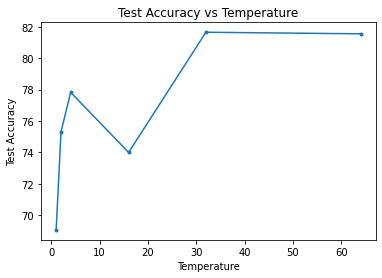

In [25]:
plt.figure()
T = [1,2,4,16,32,64]
plt.plot(T, MF1,'.-')
#plt.axis([1, 64, 98, 99])
plt.title("Test Accuracy vs Temperature")
plt.xlabel('Temperature')
plt.ylabel('Test Accuracy')
plt.show()

# Train student from scratch

In [21]:
# Build fully connected student.
MobileNetV2 = tf.keras.Sequential()

# your code start from here for step 7

MobileNetV2.add(tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape = (224, 224, 3), classifier_activation = None))
MobileNetV2.add(tf.keras.layers.Dense(NUM_CLASSES)) 
MobileNetV2.summary()

def compute_plain_cross_entropy_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = MobileNetV2(images, training=True)
  cross_entropy_loss = cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits/DISTILLATION_TEMPERATURE))*DISTILLATION_TEMPERATURE**2
  
  return cross_entropy_loss



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 2)                 2002      
                                                                 
Total params: 3,540,986
Trainable params: 3,506,874
Non-trainable params: 34,112
_________________________________________________________________


In [22]:
# student from scratch Model
# initial
NUM_EPOCHS = 10
train_and_evaluate(MobileNetV2, compute_plain_cross_entropy_loss,0.5,4,1e-3)
# fine
NUM_EPOCHS = 25
train_and_evaluate(MobileNetV2, compute_plain_cross_entropy_loss, 0.5, 4,1e-4)

Epoch 1: Class_accuracy:  62.1976 %
 F1-score of label 0 and label 1:  [0.7741531 0.       ] Macro-F1:  0.3871
Epoch 2: Class_accuracy:  62.1976 %
 F1-score of label 0 and label 1:  [0.7741531 0.       ] Macro-F1:  0.3871
Epoch 3: Class_accuracy:  62.3992 %
 F1-score of label 0 and label 1:  [0.7751256  0.01104972] Macro-F1:  0.3931
Epoch 4: Class_accuracy:  64.5161 %
 F1-score of label 0 and label 1:  [0.785487   0.12010445] Macro-F1:  0.4528
Epoch 5: Class_accuracy:  71.875 %
 F1-score of label 0 and label 1:  [0.8114286  0.52346575] Macro-F1:  0.6674
Epoch 6: Class_accuracy:  62.1976 %
 F1-score of label 0 and label 1:  [0.7741531 0.       ] Macro-F1:  0.3871
Epoch 7: Class_accuracy:  64.0121 %
 F1-score of label 0 and label 1:  [0.633833  0.6647059] Macro-F1:  0.6493
Epoch 8: Class_accuracy:  67.3387 %
 F1-score of label 0 and label 1:  [0.6913087 0.6757608] Macro-F1:  0.6835
Epoch 9: Class_accuracy:  70.7661 %
 F1-score of label 0 and label 1:  [0.74654377 0.6835443 ] Macro-F1:  0

In [23]:
MobileNetV2.save("Student_Model_7.h5")
MobileNetV2.save_weights("Student_Weights_7")

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [36]:
# your code start from here for step 8
!pip install keras-flops
from keras_flops import get_flops

     |████████████████████████████████| 462 kB 15.0 MB/s 


In [8]:
# Load Models
# Load the previously trained teacher model
teacher_model=load('Teacher_Model_4.h5')

# Load the previously trained student model with KD
student_w_kd_model=load('Student_Model_4.h5')

# Load the previously trained student model without KD
student_wo_kd_model=load('Student_Model_7.h5')

In [38]:
# Teacher Model FLOPs
flops = get_flops(teacher_model, batch_size=1)
print("Teacher Model")
print(f"FLOPS: {flops / 10 ** 9:.03} G")
# Student Model(w/ KD) FLOPs
flops = get_flops(student_w_kd_model, batch_size=1)
print("Student Model With KD")
print(f"FLOPS: {flops / 10 ** 9:.03} G")
# Student Model(w/o KD) FLOPs
flops = get_flops(student_wo_kd_model, batch_size=1)
print("Student Model Without KD")
print(f"FLOPS: {flops / 10 ** 9:.03} G")

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Teacher Model
FLOPS: 6.99 G
Student Model With KD
FLOPS: 0.615 G
Student Model Without KD
FLOPS: 0.615 G


# XAI method to explain models

In [9]:
# your code start from here for step 9
#Code in Project A:
def create_random_mask(h=7, w=7, H=224, W=224, p_1=0.5, resample=Image.BILINEAR):
    '''
    Generates one random mask utilized in RISE
    inputs:
        h, w: initial size of binary mask
        H, W: final size of the upsampled mask
        p_1: probability of actiating pixels in the down-sampled masks.
        interp: upsampling technique.
    returns:
        mask: a smooth mask with the values in range [0,1] with size of HxW.
    '''
    assert H>h, 'Masks should be resized to higher dimensions.'
    assert W>w, 'Masks should be resized to higher dimensions.'
    # create random binary hxw mask
    mask=np.random.choice([0, 1], size=(h, w), p=[1-p_1, p_1])

    # upsample mask to (h+H,w+W)
    mask = Image.fromarray(mask*255.)
    mask = mask.resize((H + h, W + w), resample=resample)
    mask = np.array(mask)

    # randomly crop mask to HxW
    w_crop = np.random.randint(0,w+1)
    h_crop = np.random.randint(0,h+1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]

    # normalize between 0 and 1
    mask /= np.max(mask)
    return mask

def RISE(img, model, class_index, N_MASKS=8000, H=28, W=28, C=1):
    '''
	img: a 3-D input image
	model: a trained model
	class_index; The class of interest
	N_MASKS: The number of random masks to be generated
	H,W,C: The desired dimensions of the random masks
	'''
    X = np.zeros(shape=(N_MASKS, H, W, C), dtype=np.float32)
    masks = np.zeros((N_MASKS,H,W), dtype=np.float32)
    #for i in tqdm(range(N_MASKS)):
    for i in range(N_MASKS):
        m =create_random_mask(H=H, W=W)
        masks[i] = m
        x = img.copy()
        #print(x.shape)
        #print(m.shape)
        x[:, :, 0] *= m
        #x[:, :, 1] *= m
        #x[:, :, 2] *= m
        X[i] = x
    preds_masked = model.predict(X, verbose=0)
    sum_mask = np.zeros(masks[0].shape, dtype=np.float32)

    # np.einsum???
    for i, mask in enumerate(masks):
        m = mask * preds_masked[i, class_index]
        sum_mask += m

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)
    return sum_mask

## Get a Sample Image

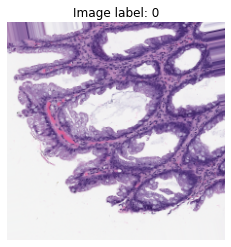

In [10]:
# Get one batch
images_batch, labels_batch = train_generator.next()

# Plot image samples
import random
random.seed(50)
number = random.randint(0,32)
sample_image = tf.squeeze(images_batch[number])
sample_label = np.argmax(labels_batch[number])
# plt.figure(figsize=(12,12))
plt.imshow(sample_image)
plt.axis("off")
plt.title("Image label: {}".format(sample_label))
plt.show()

## Predictions of Three Models

In [11]:
#Predictions from Teacher Model， Student Model w/ KD, and Student Model w/o KD
tracher_pred = np.argmax(tf.nn.softmax(teacher_model(tf.expand_dims(sample_image, axis=0))))
student_wo_kd_pred = np.argmax(tf.nn.softmax(student_wo_kd_model(tf.expand_dims(sample_image, axis=0))))
student_w_kd_pred = np.argmax(tf.nn.softmax(student_w_kd_model(tf.expand_dims(sample_image, axis=0))))
print("Teacher Predict Result:",tracher_pred,"\nStudent With KD Predict Result:",student_w_kd_pred,"\nStudent Without KD Predict Result",student_wo_kd_pred)

Teacher Predict Result: 0 
Student With KD Predict Result: 0 
Student Without KD Predict Result 0


## RISE Methods Explain the three models

In [12]:
# Get Explanation Maps from three models
Teacher_RISE = RISE(images_batch[number], teacher_model, class_index=sample_label, N_MASKS=8000, H=224, W=224, C=3)
Teacher_RISE -= Teacher_RISE.min()
Teacher_RISE /= Teacher_RISE.max()+10e-30

In [14]:
Student_w_kd_RISE = RISE(images_batch[number], teacher_model, class_index=sample_label, N_MASKS=8000, H=224, W=224, C=3)
Student_w_kd_RISE -= Student_w_kd_RISE.min()
Student_w_kd_RISE /= Student_w_kd_RISE.max()+10e-30

In [16]:
Student_wo_kd_RISE = RISE(images_batch[number], teacher_model, class_index=sample_label, N_MASKS=8000, H=224, W=224, C=3)
Student_wo_kd_RISE -= Student_wo_kd_RISE.min()
Student_wo_kd_RISE /= Student_wo_kd_RISE.max()+10e-30

(-0.5, 223.5, 223.5, -0.5)

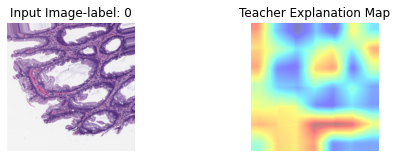

In [13]:
# Plot Three explanation map from different models
# Teacher Model
plt.figure(figsize=(8,8))
plt.subplot(3,2,1)
plt.title("Input Image-label: {}".format(sample_label))
plt.imshow(sample_image)
plt.axis("off")

plt.subplot(3,2,2)
plt.title('Teacher Explanation Map')
plt.imshow(Teacher_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

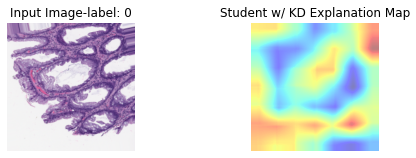

In [15]:
# Student w/ KD Model
plt.figure(figsize=(8,8))
plt.subplot(3,2,3)
plt.title("Input Image-label: {}".format(sample_label))
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(3,2,4)
plt.title('Student w/ KD Explanation Map')
plt.imshow(Student_w_kd_RISE, cmap='jet', alpha=0.5)
plt.axis('off')



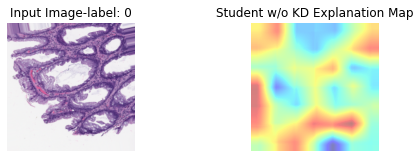

In [17]:
# Student w/o KD Model
plt.figure(figsize=(8,8))
plt.subplot(3,2,5)
plt.title("Input Image-label: {}".format(sample_label))
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(3,2,6)
plt.title('Student w/o KD Explanation Map')
plt.imshow(Student_wo_kd_RISE, cmap='jet', alpha=0.5)
plt.axis('off')

plt.show()

# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 13
